# 1. Introduction and Problem Statement

Heart failure, a condition where the heart cannot pump sufficient blood, is a significant subgroup of cardiovascular diseases, which are responsible for approximately 17 million deaths worldwide annually.

Machine learning models, when applied to clinical records, offer a promising approach for predicting patient survival, identifying critical risk factors, and uncovering patterns that may not be immediately apparent in clinical practice.

# 2. Objective

The goal of this project is to develop a predictive model for patient mortality following heart failure to examine the following hypotheses:

**Lower ejection fraction and higher serum creatinine are dominant predictors of mortality; serum sodium and age nonlinearity provide independent incremental value**

This notebook focuses on the initial phases:
1.  **Exploratory Data Analysis (EDA):** To understand the data, identify key relationships, and check for issues like missing values or imbalance.
2.  **Feature Engineering & Preprocessing:** To create new informative features and prepare the data for modeling by scaling and encoding.

The subsequent model building and evaluation are conducted in the `Model_Building_and_Evaluation.ipynb` notebook.

# 3. Import Libraries

This cell imports the necessary Python libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), feature engineering and preprocessing (scikit-learn), and artifact saving (joblib).

In [1]:
# Import packages for EDA
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for feature engineering and selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Import packages for data pipelining
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

import joblib

# 4. Data Loading and Initial Inspection

In this section, we load the dataset and perform an initial review of its structure, summary statistics, and any missing values. The `time` column, which represents the follow-up period, is dropped as we are predicting the `DEATH_EVENT` (a binary outcome) directly, not performing a time-to-event survival analysis.


In [2]:
# 1. Import data
df = pd.read_csv("../data/heart_failure_clinical_records_dataset.csv")
df = df.drop('time', axis=1)

In [3]:
# Summary statistics for numerical features
numerical_features = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
numerical_summary = df[numerical_features].describe()
numerical_summary.to_csv('reports/tables/numerical_feature_summary.csv')
numerical_summary

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000


In [4]:
# Summary statistics for categorical features
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
categorical_summary = df[categorical_features].describe()
categorical_summary.to_csv('reports/tables/categorical_feature_summary.csv')
categorical_summary

,anaemia,diabetes,high_blood_pressure,sex,smoking
count,299.000000,299.000000,299.000000,299.000000,299.00000
mean,0.431438,0.418060,0.351171,0.648829,0.32107
std,0.496107,0.494067,0.478136,0.478136,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,1.000000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000


In [5]:
# Calculate proportion of null values in each feature
null_proportions = (df.isnull().sum() / len(df))*100
null_proportions_df = pd.DataFrame(null_proportions, columns = ['Percentage of missing values'])
null_proportions_df

,Percentage of missing values
age,0.0
anaemia,0.0
creatinine_phosphokinase,0.0
diabetes,0.0
ejection_fraction,0.0
high_blood_pressure,0.0
platelets,0.0
serum_creatinine,0.0
serum_sodium,0.0
sex,0.0


### 4.1. Missing Value Analysis

The dataset is complete with no missing values, as confirmed by the output above. Therefore, no imputation steps will be required in our preprocessing pipeline.

# 5. Exploratory Data Analysis (EDA)

We will now explore the data to understand feature distributions and their relationship with the `DEATH_EVENT` target variable. This analysis will guide our feature engineering and modeling strategies.

1.  **Numerical Features:** Analyze distributions (KDE plots) and relationships with the target (box plots).
2.  **Categorical Features:** Examine class balances and their correlation with the target (count plots).
3.  **Feature Correlation:** Identify multicollinearity using a Pearson correlation heatmap.
4.  **Target Distribution:** Check for class imbalance in the `DEATH_EVENT` variable.
5. **Mutual Information:** To quantify the non-linear relationship between each feature and the target

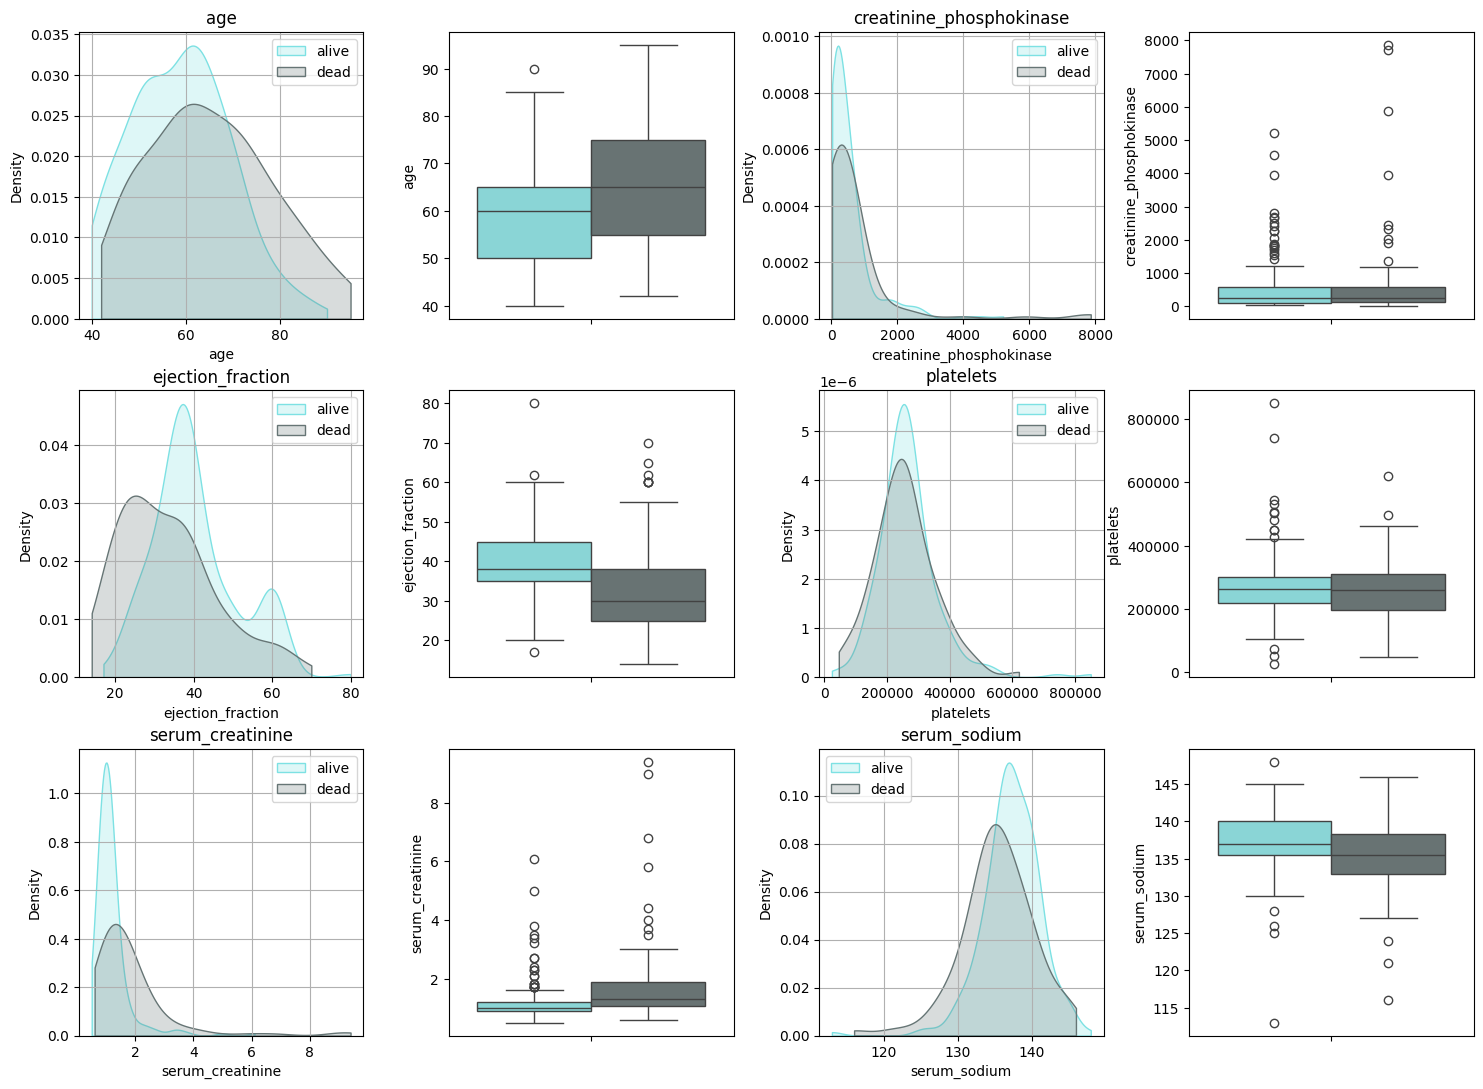

In [6]:
# 1. Find the numerical variables that correlate the most heavily with the target via kde plots and box plots
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =0.25, wspace=0.3)
    
    plt.grid(True)
    plt.title(col)
    
    # KDE plot for feature values for alive patients
    sns.kdeplot(df.loc[df['DEATH_EVENT']==0, col], label='alive', color='#7DE1E3', fill=True, cut=0)
    # KDE plot for feature values for dead patients
    sns.kdeplot(df.loc[df['DEATH_EVENT']==1, col], label='dead', color='#667575', fill=True, cut=0)
    plt.legend()
    
    # Boxplot to show feature value distribution in dead and alive patients
    plt.subplot(6, 4, i*2+2)
    sns.boxplot(data=df, y=col, hue="DEATH_EVENT", palette = ["#7DE1E3", "#667575"], legend=False)
    plt.savefig('reports/figures/numerical_feature_analysis.png')

We observe from the graphs that the most informative features seem to be ejection_fraction and serum_creatinine, which is in line with the original study.

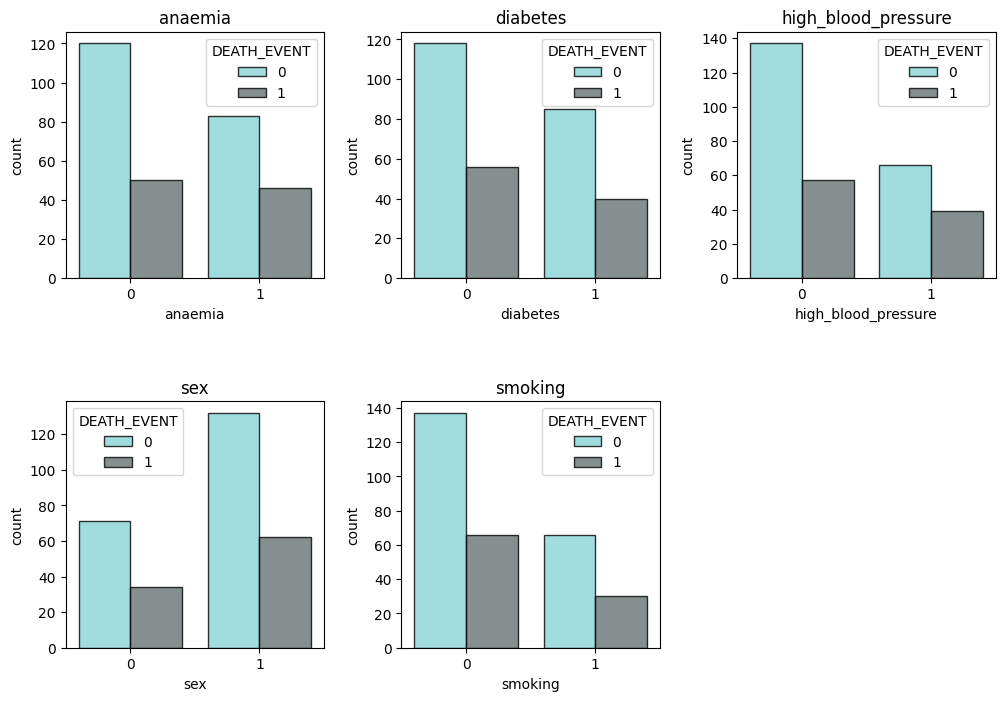

In [7]:
# 2. Find the categorical variables that correlate the most heavily with the target via count plots
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.subplots_adjust(hspace =0.15, wspace=0.3)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=df, x=col, hue="DEATH_EVENT", palette = ["#7DE1E3", "#667575"], alpha=0.8, edgecolor="k", linewidth=1)

plt.savefig('reports/figures/categorical_feature_analysis.png')

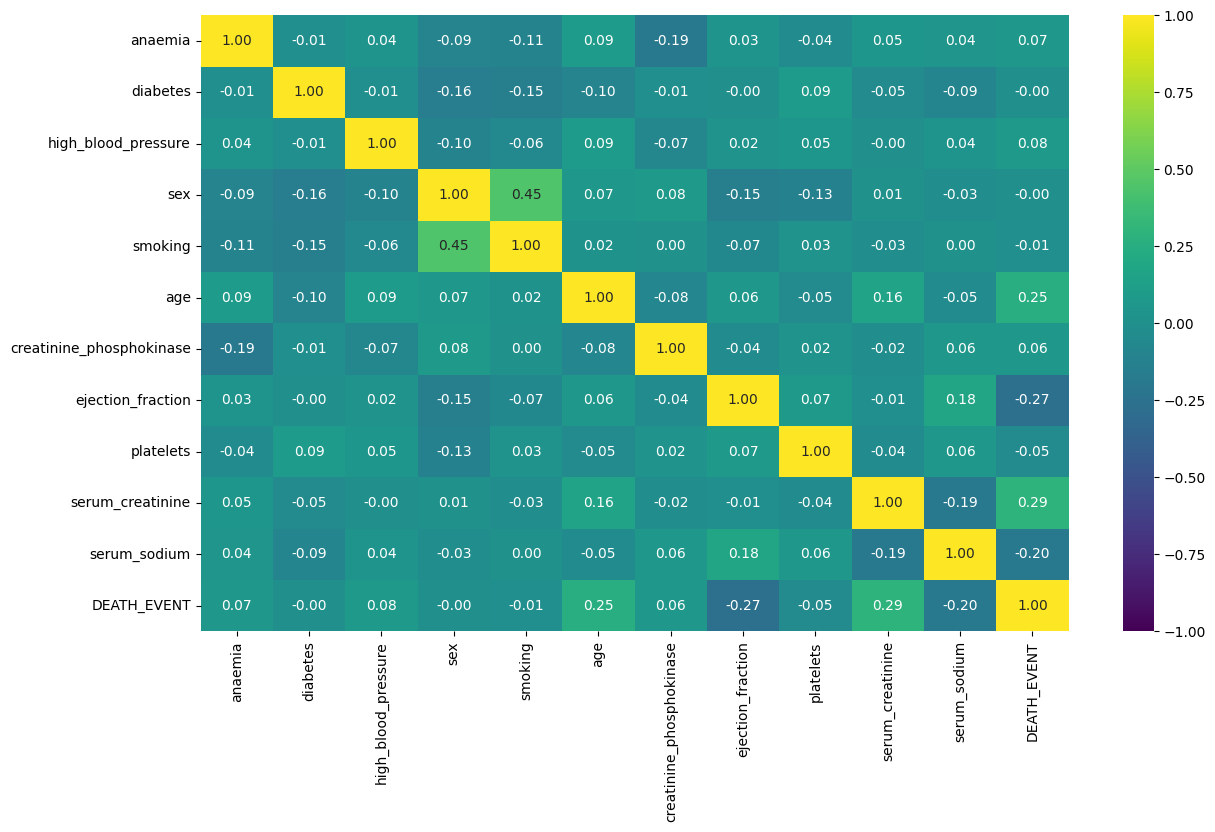

In [8]:
# 3. Plot a heatmap to find the correlation between the features
all_features = categorical_features.copy()
all_features.extend(numerical_features)
all_features.append('DEATH_EVENT')

plt.figure(figsize=(14, 8))
sns.heatmap(df[all_features].corr(method='pearson'), vmin=-1, vmax=1, cmap='viridis', annot=True, fmt='.2f')
plt.savefig('reports/figures/correlation_heatmap.png')

### 5.3. Correlation Heatmap Findings

The heatmap shows the Pearson correlation between features. We are primarily looking for signs of high **multicollinearity** (strong correlations, e.g., > 0.8 or < -0.8, between two *independent* features), as this can destabilize linear models like Logistic Regression.

**Finding:** There are no strong correlations between our primary predictors (`ejection_fraction`, `serum_creatinine`, `serum_sodium`, `age`). This indicates that multicollinearity will not be a significant issue for our models.

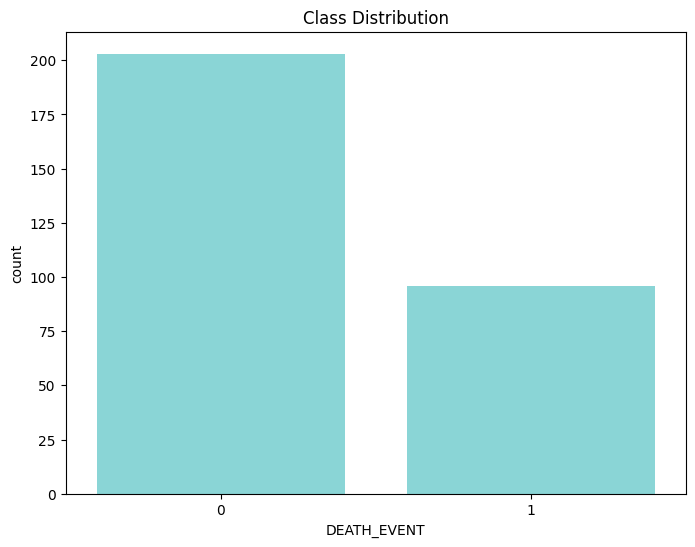

In [19]:
# 4. Use a count plot to show that class distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='DEATH_EVENT', data=df, color='#7DE1E3')
plt.title('Class Distribution')
plt.savefig('reports/figures/class_distribution.png')

### 5.4. Target Variable Distribution Findings

**Finding:** The count plot for `DEATH_EVENT` (where 1 = Death) confirms that the dataset is **imbalanced**. There are significantly more survival events (0) than death events (1).

This has two key implications for our modeling strategy:
1.  **Metrics:** Standard accuracy is a poor metric. We must prioritize **PR-AUC** (Precision-Recall Area Under Curve), which is more informative for imbalanced classes.
2.  **Training:** Our models must account for this imbalance. We will use techniques like `class_weight='balanced'` during model training to prevent the model from simply defaulting to the majority class.

### 5.5. Mutual Information Analysis

To further quantify the non-linear relationship between each feature and the target, we calculate the Mutual Information (MI) score. This metric captures any kind of dependency (not just linear correlation) and helps confirm the importance of our selected features.

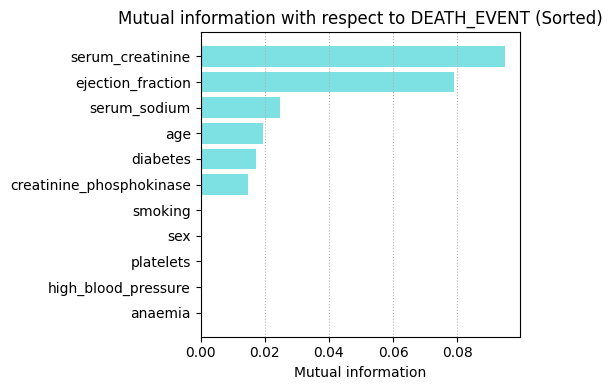

In [10]:
features_df = df.select_dtypes(include=['number']).drop(columns=['DEATH_EVENT', 'time'], errors='ignore')
target_series = df['DEATH_EVENT']

# 3. Calculate mutual information
mi_scores = mutual_info_classif(features_df, target_series, n_neighbors=20, random_state=42)

# 4. Create a sorted DataFrame for plotting
mi_df = pd.DataFrame({
    'feature': features_df.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=True)

# 5. Create the plot
plt.figure(figsize=(5.4, 4))
plt.barh(y=mi_df['feature'], width=mi_df['mi_score'], color="#7DE1E3")
plt.title("Mutual information with respect to DEATH_EVENT (Sorted)")
plt.xlabel("Mutual information")
plt.gca().xaxis.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig('reports/figures/mutual_information.png')

### 5.5.1. Mutual Information Findings

The Mutual Information (MI) scores confirm our observations from the KDE plots.
* **High Importance:** `ejection_fraction` and `serum_creatinine` have the highest MI scores by a significant margin, confirming their strong predictive relationship with the `DEATH_EVENT`.
* **Moderate Importance:** `age`, `diabetes` and `creatine_phosphokinase` also show a clear signal.
* **Low Importance:** Features like `sex`, `diabetes`, and `anaemia` have very low MI scores, suggesting they offer little independent predictive value.

This analysis validates our decision to build hypothesis-driven feature sets focused on `ejection_fraction`, `serum_creatinine`, `serum_sodium` and `age`.

# 6. Feature Engineering and Preprocessing Pipeline

Based on the EDA findings and clinical domain knowledge, we will now define our complete data transformation process.

In [11]:
# Split the data into training and testing data
x=df.drop(['DEATH_EVENT'],axis=1)
y=df['DEATH_EVENT']

# Split test data
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

# Split validation data
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=1)

# This ensures all sets have a clean, sequential index 
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True) 

In [12]:
# New features created
engineered_numerical_features = [
    'age_squared',
    'log_cpk',
    'age_creatinine',
    'ejection_sodium'
]

# New categorical features created
engineered_categorical_features = [
    'ckd_stage',
    'ef_category'
]

# Combined feature lists
all_numerical_features = numerical_features + engineered_numerical_features
all_categorical_features = categorical_features + engineered_categorical_features
all_features = all_numerical_features + all_categorical_features

### 6.1. Feature Transformation and Selection Functions

We define helper functions to be used within our scikit-learn pipeline:

* `feature_engineering`: Creates new interaction terms (e.g., `age_creatinine`) and non-linear terms (e.g., `age_squared`) based on our hypotheses. It also bins clinical markers (`serum_creatinine`, `ejection_fraction`) into clinically relevant categories.

* `feature_selection`: This is a helper function designed for experimentation to remove low-importance features identified during EDA (based on the MI scores). It will not be used in the final, canonical pipeline, as we want to test our hypotheses on specific feature subsets in the next notebook.

In [13]:
# feature selection helper function which will be used in the pipeline
def feature_selection(X):
    # Drop unimportant categorical features as determined by mutual information
    features_to_drop = ['smoking', 'high_blood_pressure', 'platelets', 'diabetes', 'anaemia']
    
    existing_features_to_drop = [col for col in features_to_drop if col in X.columns]
    X = X.drop(columns=existing_features_to_drop, errors='ignore')
    
    return X
    
def feature_engineering(X):
    X=X.copy()
    
    # Add non-linear terms
    X['age_squared'] = X['age'] ** 2   # Captures accelerating risk with age
    X['log_cpk'] = np.log1p(X['creatinine_phosphokinase'])   # Handles right-skewed enzyme levels

    # Gives interaction terms
    X['age_creatinine'] = X['age'] * X['serum_creatinine']
    X['ejection_sodium'] = X['ejection_fraction'] * X['serum_sodium']

    # Binning of clinical markers
    X['ckd_stage'] = pd.cut(X['serum_creatinine'],
                    bins=[0, 1.2, 2.0, 3.0, float('inf')],
                    labels=['normal', 'mild', 'moderate', 'severe'])

    X['ef_category'] = pd.cut(X['ejection_fraction'],
                        bins=[0, 35, 50, float('inf')],
                        labels=['severe', 'moderate', 'normal'])
    
    return X

### 6.2. Pipeline Definition

We will now construct a `scikit-learn` pipeline to automate all transformations. This pipeline will:
1.  Apply the `feature_engineering` function to create new features.
2.  Apply a `ColumnTransformer` to:
    * **Numerical Features:** Impute missing values (if any) with the median and scale the data using `RobustScaler`, which is insensitive to the outliers we observed in the EDA.
    * **Categorical Features:** Impute missing values (if any) with the most frequent value and then apply `OneHotEncoder` to convert them into a machine-readable format.

In [14]:
final_numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 
                           'serum_creatinine', 'serum_sodium', 'age_squared', 
                           'log_cpk', 'age_creatinine', 'ejection_sodium', 'platelets']

final_categorical_features = ['sex', 'ckd_stage', 'ef_category']


# Preprocessing for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, final_numerical_features),
        ('cat', categorical_transformer, final_categorical_features)
    ],
    verbose_feature_names_out=False
)

# Create full pipeline
pipeline = Pipeline(steps=[
    ('feature_engineering',  FunctionTransformer(feature_engineering)),
    ('preprocessor', preprocessor)
])
pipeline.set_output(transform="pandas")

Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x7f57935c9310>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age',
                                                   'creatinine_phosphokinase',
                                                   'ejection_fraction',
                                                   'serum_creatinine',
                                                   'serum_sodium',
                                                   'age_squared', 'log_cpk',
                                                   'age_creatinine',
                                                   'ejection_sodium',
                                                   'platelets']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'ckd_stage',
                                                   'ef_category'])],
                                   verbose_feature_names_out=False))])

### 6.3. Apply Pipeline and Save Artifacts

We fit the complete pipeline on the `x_train` data. This step "learns" the median and interquartile range (IQR) from `RobustScaler` and the unique categories from `OneHotEncoder` based *only* on the training data.

This fitted pipeline is then used to transform the `x_train`, `x_val`, and `x_test` sets. The final pipeline object and all transformed data splits are serialized using `joblib` and saved to the `artifacts/` directory for use in the model building notebook.

In [15]:
# Fit the pipeline on training data and transform it
X_train_transformed = pipeline.fit_transform(x_train)

# Now transform validation data using the fitted pipeline
X_val_transformed = pipeline.transform(x_val)

# Transform test data
X_test_transformed = pipeline.transform(x_test)

In [16]:
# Save the pipeline
joblib.dump(pipeline, 'artifacts/pipeline.joblib')

# Save the test and train splits
joblib.dump(X_train_transformed, 'artifacts/splits/x_train.joblib')
joblib.dump(y_train, 'artifacts/splits/y_train.joblib')
joblib.dump(X_val_transformed, 'artifacts/splits/x_val.joblib')
joblib.dump(y_val, 'artifacts/splits/y_val.joblib') 
joblib.dump(X_test_transformed, 'artifacts/splits/x_test.joblib')
joblib.dump(y_test, 'artifacts/splits/y_test.joblib')

['artifacts/splits/y_test.joblib']